# Measuring the offensiveness of a song

First things first, the most important thing we want to have for our project is a way to measure the offensiveness of a song. We will do this by counting the number of offensive words in a song. 

## Setting up a Dataframe for the rating of offensiveness
I'm using a paper released by the British telecommunications regulator Ofcom: https://www.ofcom.org.uk/__data/assets/pdf_file/0023/91625/OfcomQRG-AOC.pdf

There is a useful transcription here:
http://metro.co.uk/2016/10/02/swearing-ranked-from-mild-to-strongest-6165629/#

I created a JSON file from the data of that website.
This notebook will load this file and convert it to a Dataframe with a usable layout.

In [1]:
import json
import pandas as pd
import sqlite3
from tqdm import tqdm
import numpy as np
import h5py
import os
import glob
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
with open("../datasets/metro_co_uk_transcription.json") as file:
    offensiveness_rating = json.load(file)
    
# the offensiveness rating is a nested JSON file
# after three levels of json objects, there is a list of words
# it looks like this:
print(offensiveness_rating["discriminatory"]["religion"]["strong"])
print(offensiveness_rating["discriminatory"]["race"]["medium"])

# there are also offensive words that are not discriminating
# for them, the second key doesn't really make sense, I just entered "offensive"
print(offensiveness_rating["non-discriminatory"]["offensive"]["mild"])

['Fenian', 'Kafir', 'Kufaar', 'Kike', 'Papist', 'Prod', 'Taig', 'Yid']
['Kraut', 'Pikey', 'Taff']
['Arse', 'Bloody', 'Bugger', 'Cow', 'Crap', 'Damn', 'Ginger', 'Git', 'God', 'Goddam', 'Jesus Christ', 'Minger', 'Sod-off']


In [3]:
# for further processing, we want to have a dataframe with the words as index
# a cell in the dataframe should be a word and the rating of offensiveness
# if the word is discriminating, we also want to have the target group

entries = []

def clean(word):
    return word.strip().lower()

# words are always three levels down in the file
for category, value in offensiveness_rating.items():
    for target, value in value.items():
        for strength, words in value.items():
            for word in words:
                entry = {}
                entry["category"] = clean(category)
                entry["word"] = clean(word)
                entry["strength"] = clean(strength)
                
                assert category in ["discriminatory", "non-discriminatory"]
                
                if category=="discriminatory":
                    entry["target"] = clean(target)
                else:
                    entry["target"] = None
                
                entries.append(entry)

In [4]:
entries[:2]

[{'category': 'non-discriminatory',
  'strength': 'mild',
  'target': None,
  'word': 'bonk'},
 {'category': 'non-discriminatory',
  'strength': 'strong',
  'target': None,
  'word': 'bukkake'}]

In [6]:
word_table = pd.DataFrame(entries)
word_table.head(5)

,category,strength,target,word
0,non-discriminatory,mild,None,bonk
1,non-discriminatory,strong,None,bukkake
2,non-discriminatory,strong,None,cocksucker
3,non-discriminatory,strong,None,dildo
4,non-discriminatory,strong,None,ho


In [7]:
word_table= word_table.set_index("word")
word_table.head(5)

,category,strength,target
word,,,
bonk,non-discriminatory,mild,None
bukkake,non-discriminatory,strong,None
cocksucker,non-discriminatory,strong,None
dildo,non-discriminatory,strong,None
ho,non-discriminatory,strong,None


In [8]:
word_table.to_pickle("../pickles/word_table.pickle")

### Checking our list of swearwords

The musixmatch database contains lyrics for a selection of tracks from the million-song-database.

But the lyrics are only given by wordcount. So for any given song, we don't have the actual text, but only the number of times that the singer has said "I" or "you".

This makes the rating of offensiveness much harder, since we lose all context.
For example: "Jesus Christ" and "god" are rated as mildly offensive and non-discriminatory. If you use them as expletive, that might be correct. But we still don't want to classify gospel songs as outliers with a high frequency of mild swearing.

In this notebook we load all words that are present in the lyrics and check which of them are covered in our list of swearwords.
Then we go through the lyrics again, to check if our swearwords are missing something.

In [2]:
conn = sqlite3.connect("../datasets/mxm_dataset.db")

In [3]:
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('words',), ('lyrics',)]


In [4]:
cursor = conn.cursor()
cursor.execute("SELECT * FROM words;")
words = cursor.fetchall()
words[:5]

[('i',), ('the',), ('you',), ('to',), ('and',)]

In [6]:
word_table = pd.read_pickle("../pickles/word_table.pickle")
word_table.head()

,category,strength,target
word,,,
bonk,non-discriminatory,mild,None
bukkake,non-discriminatory,strong,None
cocksucker,non-discriminatory,strong,None
dildo,non-discriminatory,strong,None
ho,non-discriminatory,strong,None


In [7]:
for word in words:
    if word[0] in word_table.index:
        print(word)

('god',)
('fuck',)
('shit',)
('damn',)
('ho',)
('bitch',)
('special',)
('dick',)
('whore',)
('mental',)
('bastard',)
('negro',)
('bullshit',)
('cock',)
('cow',)
('slut',)
('psycho',)
('cunt',)
('crap',)


In [8]:
# I read all the words in the database
# this is a manual list of swearwords
# please note that I'm not a native speaker, it is possible that I've missed something

# this is a list of words that are with very high likelihood used as swearwords,
# or that are obviously obscene.
offensive_list = ["fuck", "fool", "shit", "nigga", "damn", "bitch", "ass", "fuckin", "freak", "motherfuck", "rape", "dick", "whore", "bastard", "sucker", "pussi",
"bum", "gay", "cock", "jerk", "cunt", "junk", "motherfuckin", "crap"]
         
# the second list of words is colloquial
# they might be offensive, but it's not really clear without context
colloquial_list = ["trippin","thug","gangsta","gypsi","booti","junki","shorti"]
                  
# then we have a third list
# I've only filled this with exemplary samples
# the third list contains very negative words
# but these words are not offensive
negative_list = ["slave"," satan","suicid","cocain","genocid"]

## Cleaning the swearwords

Based on the data above, we have to clear our list of swearwords.
We remove
 - negro, because that is probably just Spanish
 - god, because this is only offensive in context
 
The words found above, that are not in the list of swearwords will be added based on their similarity to existing words.
For most additions, the choice of strength and category seems easy. Here is a list of choices that might be discussed:

- "freak", similar to "retard" or "spastic"
- "jerk", similar to "bastard"
- "booti", similar to "arse"

We also add some words from the colloquial list
 - gypsi
 - shorti

In [9]:
word_table = word_table.drop("negro")
word_table = word_table.drop("god")


In [10]:
# fuck exists

# we add fool, similar to "loony", "mental" 
word_table.loc["fool"]={"category":"discriminatory", "strength":"mild", "target":"mental or physical ability"}

# shit exists

# we add nigga, similar to nigger
word_table.loc["nigga"]={"category":"discriminatory", "strength":"strongest", "target":"race"}

# damn exists
# bitch exists

# we add ass, similar to arse
word_table.loc["ass"]={"category":"non-discriminatory", "strength":"mild", "target":None}

# we add fuckin, similar to fuck
word_table.loc["fuckin"]={"category":"non-discriminatory", "strength":"strongest", "target":None}

# we add freak, similar to retard
word_table.loc["freak"]={"category":"discriminatory", "strength":"strongest", "target":"mental or physical ability"}

# we add motherfuck and motherfuckin, similar to motherfucker
word_table.loc["motherfuck"]={"category":"non-discriminatory", "strength":"strongest", "target":None}
word_table.loc["motherfuckin"]={"category":"non-discriminatory", "strength":"strongest", "target":None}

# we add rape, similar to rapey
word_table.loc["rape"]={"category":"non-discriminatory", "strength":"strongest", "target":None}

# dick already exists
# whore already exists


# we add bum, similar to arse
word_table.loc["bum"]={"category":"non-discriminatory", "strength":"mild", "target":None}

# we add gay, similar to homo
word_table.loc["gay"]={"category":"discriminatory", "strength":"strong", "target":"sexuality"}

# we add cock, similar to dick
word_table.loc["cock"]={"category":"non-discriminatory", "strength":"strong", "target":None}

# we add jerk, similar to bastard
word_table.loc["jerk"]={"category":"non-discriminatory", "strength":"strong", "target":None}

# we add junk, similar to Crap
word_table.loc["junk"]={"category":"non-discriminatory", "strength":"mild", "target":None}

# we add booty, similar to arse
word_table.loc["booti"]={"category":"non-discriminatory", "strength":"mild", "target":None}

In [11]:
# we add shorti, mildly discriminative against women
word_table.loc["shorti"]={"category":"discriminatory", "strength":"mild", "target":"sexuality"}

# we add gypsi, medium discriminative against gypsies
word_table.loc["gypsi"]={"category":"discriminatory", "strength":"medium", "target":"race"}

## Checking occurence of words again
We go through all words that occur in the lyrics and check against our list of swearwords.
The resulting list should only contain words that are obviously swearwords.

We save the resulting dataframe

In [12]:
for word in words:
    if word[0] in word_table.index:
        print(word)

('fuck',)
('fool',)
('shit',)
('nigga',)
('damn',)
('ho',)
('bitch',)
('ass',)
('special',)
('fuckin',)
('freak',)
('motherfuck',)
('rape',)
('dick',)
('whore',)
('mental',)
('bastard',)
('bum',)
('bullshit',)
('gay',)
('cock',)
('gypsi',)
('cow',)
('jerk',)
('booti',)
('shorti',)
('slut',)
('psycho',)
('cunt',)
('junk',)
('motherfuckin',)
('crap',)


In [13]:
word_table.to_pickle("../pickles/word_table_cleaned.pickle")

### Rating a song in the msd database (obsolete)
This was a first attempt to rate the offensiveness of a song in the database.
To do this, we need to
- identify an individual song
- get all lyrics corresponding to this song
- rate them by offensiveness

In this notebook, we are investigating the structure of the data.
But our approach is not fast enough.

In [3]:
conn = sqlite3.connect("../datasets/mxm_dataset.db")

The database contains the following:

https://github.com/tbertinmahieux/MSongsDB/blob/master/Tasks_Demos/Lyrics/README.txt
_More details on the database:
   - it contains two tables, 'words' and 'lyrics'
   - table 'words' has one column: 'word'. Words are entered according
     to popularity, check their ROWID if you want to check their position.
     ROWID is an implicit column in SQLite, it starts at 1.
   - table 'lyrics' contains 5 columns, see below
   - column 'track_id' -> as usual, track id from the MSD
   - column 'mxm_tid' -> track ID from musiXmatch
   - column 'word' -> a word that is also in the 'words' table
   - column 'cnt' -> word count for the word
   - column 'is_test' -> 0 if this example is from the train set, 1 if test_
   
We want to connect our insights to the million song database and its metadata.
Therefore we want to use the track_id to identify songs.

The lyrics table contains individual entries for every 

In [4]:
# this is the content of the lyrics table
# please note that it's not "cnt" but "count", the README is wrong
cursor = conn.cursor()
cursor.execute("PRAGMA table_info(lyrics);")
print(cursor.fetchall())
cursor.close()

[(0, 'track_id', '', 0, None, 0), (1, 'mxm_tid', 'INT', 0, None, 0), (2, 'word', 'TEXT', 0, None, 0), (3, 'count', 'INT', 0, None, 0), (4, 'is_test', 'INT', 0, None, 0)]


### Use SQL to extract information

We want to have all track ids, and for every track id, we need the words and counts

The data is big, but even as a pandas DataFrame, the size stays below 5GB.
I think the comfort of pandas is enough to warrant loading this into memory.

In [5]:
cursor = conn.cursor()
cursor.execute("SELECT DISTINCT track_id FROM lyrics ORDER BY track_id;")
track_ids = cursor.fetchall()
cursor.close()
track_ids[:5]

[('TRAAAAV128F421A322',),
 ('TRAAABD128F429CF47',),
 ('TRAAAED128E0783FAB',),
 ('TRAAAEF128F4273421',),
 ('TRAAAEW128F42930C0',)]

In [6]:
cursor = conn.cursor()
cursor.execute("SELECT track_id, word, count FROM lyrics ORDER BY track_id;")
track_word_count = cursor.fetchall()
cursor.close()
track_word_count[:5]

[('TRAAAAV128F421A322', 'i', 6),
 ('TRAAAAV128F421A322', 'the', 4),
 ('TRAAAAV128F421A322', 'you', 2),
 ('TRAAAAV128F421A322', 'to', 2),
 ('TRAAAAV128F421A322', 'and', 5)]

In [7]:
conn.close()

In [9]:
id_series = pd.Series(track_ids)
track_ids[:5]

[('TRAAAAV128F421A322',),
 ('TRAAABD128F429CF47',),
 ('TRAAAED128E0783FAB',),
 ('TRAAAEF128F4273421',),
 ('TRAAAEW128F42930C0',)]

In [10]:
sqldb_frame = pd.DataFrame(track_word_count, columns=["track_id", "word", "count"])
del track_word_count

### Constructing a table to hold song ratings

We want to create a table which allows intuitive indexing into the rating of a song.

The table will contain the frequency of each word category. We set up a multiindex to allow slicing along the different characteristics of the word

In [11]:
word_table = pd.read_pickle("../pickles/word_table_cleaned.pickle")

In [12]:
word_table.head()

,category,strength,target
word,,,
bonk,non-discriminatory,mild,None
bukkake,non-discriminatory,strong,None
cocksucker,non-discriminatory,strong,None
dildo,non-discriminatory,strong,None
ho,non-discriminatory,strong,None


In [13]:
index_tuples=[]

for strength in ["mild", "medium", "strong", "strongest"]:
    for category in ["discriminatory", "non-discriminatory"]:
        for target in ["None", "race", "mental or physical ability", "sexuality"]:
            index_tuples.append([strength, category, target])

In [14]:
index = pd.MultiIndex.from_tuples(index_tuples, names=["strength", "category", "target"])

In [15]:
rating_frame = pd.DataFrame(index=["track_id"], columns = index)

In [16]:
rating_frame

strength           mild                                            \
category discriminatory                                             
target             None race mental or physical ability sexuality   
track_id            NaN  NaN                        NaN       NaN   

strength                                                               \
category non-discriminatory                                             
target                 None race mental or physical ability sexuality   
track_id                NaN  NaN                        NaN       NaN   

strength         medium         ...                        strong            \
category discriminatory         ...            non-discriminatory             
target             None race    ...    mental or physical ability sexuality   
track_id            NaN  NaN    ...                           NaN       NaN   

strength      strongest                                            \
category discriminatory                                             
target             None race mental or physical ability sexuality   
track_id            NaN  NaN                        NaN       NaN   

strength                                                               
category non-discriminatory                                            
target                 None race mental or physical ability sexuality  
track_id                NaN  NaN                        NaN       NaN  

[1 rows x 32 columns]

## Populate the rating frame

### First let's look at a sample song

In [17]:
for track_id in id_series:
    print(track_id)
    break

('TRAAAAV128F421A322',)


In [18]:
mentioned_words = sqldb_frame[sqldb_frame["track_id"]==track_id[0]]

In [19]:
def fill_entry(mentioned_words):

    entry = {}
    total_count = 0

    for index, row in mentioned_words.iterrows():
        word = row["word"]
        count = row["count"]
        total_count+=count

        if word in word_table.index:
            rating = word_table.loc[word]
            strength = rating["strength"]
            category = rating["category"]
            target = rating["target"]

            if target==None:
                target="None"
            
            index = (strength, category, target)
            if index in entry:
                entry[index] += count
            else:
                entry[index] = count
                
    if total_count >0:
        normalized={}
        for key, value in entry.items():
            normalized[key] = value / total_count


        return normalized
    else:
        return entry

fill_entry(mentioned_words)

{('mild', 'non-discriminatory', 'None'): 0.009708737864077669}

In [20]:
5

5

### Now add all songs to the rating_frame
This takes much too long.

The hotspot is searching for the words in this track.
Maybe we can have a group by or something similar before this ?

Or we need to run this on the cluster.

In [22]:
for track_id in tqdm(id_series):
    track_id = track_id[0]
    mentioned_words = sqldb_frame[sqldb_frame["track_id"]==track_id]
    entry = fill_entry(mentioned_words)
    
    if entry == None:
        print("bad: "+track_id)
    else:
        rating_frame.loc[track_id, :]=entry

  0%|          | 45/237662 [00:48<72:03:02,  1.09s/it]

KeyboardInterrupt: 

We were obliged to interrupt this process because it is waaay too long. So we will find another way to do this.

## Restructure our table

We flatten the table of offensive words. This means that we can now use it in combination with technologies such as spark - that don't support multiindex structures.

In [3]:
word_table = pd.read_pickle("../pickles/word_table_cleaned.pickle")

In [4]:
word_table.head()

,category,strength,target
word,,,
bonk,non-discriminatory,mild,None
bukkake,non-discriminatory,strong,None
cocksucker,non-discriminatory,strong,None
dildo,non-discriminatory,strong,None
ho,non-discriminatory,strong,None


In [5]:
word_table["descriptor"] = word_table[["category", "strength", "target"]].apply(tuple, axis=1)

In [6]:
word_table.head()

,category,strength,target,descriptor
word,,,,
bonk,non-discriminatory,mild,None,"(non-discriminatory, mild, None)"
bukkake,non-discriminatory,strong,None,"(non-discriminatory, strong, None)"
cocksucker,non-discriminatory,strong,None,"(non-discriminatory, strong, None)"
dildo,non-discriminatory,strong,None,"(non-discriminatory, strong, None)"
ho,non-discriminatory,strong,None,"(non-discriminatory, strong, None)"


In [7]:
word_table_filtered = word_table["descriptor"]

In [8]:
word_table_filtered.head()

word
bonk            (non-discriminatory, mild, None)
bukkake       (non-discriminatory, strong, None)
cocksucker    (non-discriminatory, strong, None)
dildo         (non-discriminatory, strong, None)
ho            (non-discriminatory, strong, None)
Name: descriptor, dtype: object

In [10]:
word_table_filtered.to_csv("../datasets/word_table.csv", header=True)

## Parallelizing the computation
The loop-based approach to process each track id individually is taking too long.
Now we will leverage the data processing capabilities of pandas.

We use an outer join to combine lyrics with track ids. Then we aggregate the results for individual songs.

In [2]:
word_table = pd.read_csv("../datasets/word_table.csv")
word_table.head()

,word,descriptor
0,bonk,"('non-discriminatory', 'mild', None)"
1,bukkake,"('non-discriminatory', 'strong', None)"
2,cocksucker,"('non-discriminatory', 'strong', None)"
3,dildo,"('non-discriminatory', 'strong', None)"
4,ho,"('non-discriminatory', 'strong', None)"


In [3]:
word_table["word"]=word_table["word"].astype(str)
word_table.index = word_table["word"]
word_table = word_table["descriptor"]
word_table.head()

word
bonk            ('non-discriminatory', 'mild', None)
bukkake       ('non-discriminatory', 'strong', None)
cocksucker    ('non-discriminatory', 'strong', None)
dildo         ('non-discriminatory', 'strong', None)
ho            ('non-discriminatory', 'strong', None)
Name: descriptor, dtype: object

In [5]:
conn = sqlite3.connect("../datasets/mxm_dataset.db")

cursor = conn.cursor()
cursor.execute("SELECT track_id, word, count FROM lyrics ORDER BY track_id;")
track_word_count = cursor.fetchall()
cursor.close()
track_word_count[:5]

[('TRAAAAV128F421A322', 'i', 6),
 ('TRAAAAV128F421A322', 'the', 4),
 ('TRAAAAV128F421A322', 'you', 2),
 ('TRAAAAV128F421A322', 'to', 2),
 ('TRAAAAV128F421A322', 'and', 5)]

In [6]:
sqldb_frame = pd.DataFrame(track_word_count, columns=["track_id", "word", "count"])
del track_word_count

In [7]:
sqldb_frame["word"]=sqldb_frame["word"].astype(str)

## Performing an outer joint to match words between lyrics and offensiveness rating

In [8]:
joint = sqldb_frame.join(word_table, on="word", how="left", lsuffix='_caller', rsuffix='_other')
print(joint.shape)
joint.head()

(19045332, 4)


,track_id,word,count,descriptor
0,TRAAAAV128F421A322,i,6,NaN
1,TRAAAAV128F421A322,the,4,NaN
2,TRAAAAV128F421A322,you,2,NaN
3,TRAAAAV128F421A322,to,2,NaN
4,TRAAAAV128F421A322,and,5,NaN


In [9]:
obscene_indices = joint["descriptor"].astype("str")!="nan"

In [10]:
np.any(obscene_indices)

True

In [11]:
np.sum(obscene_indices)

83542

In [12]:
joint_indexed = joint.set_index(["track_id", "descriptor"])
joint_indexed.loc[("TRAADYI128E078FB38",),]

,word,count
descriptor,,
NaN,i,16
NaN,the,26
NaN,you,6
NaN,to,13
NaN,and,29
NaN,a,2
NaN,me,3
NaN,it,7
NaN,not,5


## Aggregating the data
The joint table uses track ids and offensiveness categories as indices. This is what we want, but we still have individual cells for every word.

Now we aggregate the items for every index. We sum the entries. This gives us the total count of words in each category.

In [19]:
joint_indexed.index.is_unique

False

In [20]:
joint_indexed_filtered = joint_indexed["count"]
joint_indexed_filtered.head()

track_id            descriptor
TRAAAAV128F421A322  NaN           6
                    NaN           4
                    NaN           2
                    NaN           2
                    NaN           5
Name: count, dtype: int64

In [21]:
joint_aggregated = joint_indexed_filtered.agg("sum")

In [22]:
offensiveness_rating = joint_indexed_filtered.groupby(str, axis=0).agg("sum")

In [23]:
offensiveness_rating.head()

('TRAAAAV128F421A322', "('non-discriminatory', 'mild', None)")      1
('TRAAAAV128F421A322', nan)                                       102
('TRAAABD128F429CF47', nan)                                       226
('TRAAAED128E0783FAB', nan)                                       421
('TRAAAEF128F4273421', nan)                                       139
Name: count, dtype: int64

In [24]:
offensiveness_rating.to_pickle("../pickles/offensiveness_rating_unstructured")

## Parallelizing the computation, 2nd approach

In the last notebook we have created a table of track ids and offensiveness.
But we have lost the detailed multi-index structure.

The flattening is not necessary for pandas outer-join to work.
We repeat the procedure and generate a second table which has a deeply nested multiindex.

The structure of this subsection is basically identical to the previous one.

In [3]:
word_table = pd.read_pickle("../pickles/word_table_cleaned.pickle")
word_table.head()

,category,strength,target
word,,,
bonk,non-discriminatory,mild,None
bukkake,non-discriminatory,strong,None
cocksucker,non-discriminatory,strong,None
dildo,non-discriminatory,strong,None
ho,non-discriminatory,strong,None


In [5]:
conn = sqlite3.connect("../datasets/mxm_dataset.db")

cursor = conn.cursor()
cursor.execute("SELECT track_id, word, count FROM lyrics ORDER BY track_id;")
track_word_count = cursor.fetchall()
cursor.close()
track_word_count[:5]

[('TRAAAAV128F421A322', 'i', 6),
 ('TRAAAAV128F421A322', 'the', 4),
 ('TRAAAAV128F421A322', 'you', 2),
 ('TRAAAAV128F421A322', 'to', 2),
 ('TRAAAAV128F421A322', 'and', 5)]

In [6]:
sqldb_frame = pd.DataFrame(track_word_count, columns=["track_id", "word", "count"])
del track_word_count

In [7]:
sqldb_frame["word"]=sqldb_frame["word"].astype(str)

## Performing an outer joint to match words between lyrics and offensiveness rating

In [8]:
joint = sqldb_frame.join(word_table, on="word", how="left", lsuffix='_caller', rsuffix='_other')
print(joint.shape)
joint.head()

(19045332, 6)


,track_id,word,count,category,strength,target
0,TRAAAAV128F421A322,i,6,NaN,NaN,NaN
1,TRAAAAV128F421A322,the,4,NaN,NaN,NaN
2,TRAAAAV128F421A322,you,2,NaN,NaN,NaN
3,TRAAAAV128F421A322,to,2,NaN,NaN,NaN
4,TRAAAAV128F421A322,and,5,NaN,NaN,NaN


In [9]:
joint_indexed = joint.set_index(["track_id", "category", "strength", "target"])
joint_indexed.loc[("TRAADYI128E078FB38",),]

word  count
category           strength  target                      
NaN                NaN       NaN                 i     16
                             NaN               the     26
                             NaN               you      6
                             NaN                to     13
                             NaN               and     29
                             NaN                 a      2
                             NaN                me      3
                             NaN                it      7
                             NaN               not      5
                             NaN                in      9
                             NaN                my     29
                             NaN                is     10
                             NaN                of      1
                             NaN              your      3
                             NaN              that      6
                             NaN                do     23
                             NaN                on      7
                             NaN               are      2
                             NaN                we     29
                             NaN                am      3
                             NaN              will      4
                             NaN               all     38
                             NaN               for      1
                             NaN                no      1
                             NaN                be      1
                             NaN              have      1
                             NaN              love      2
                             NaN                so      1
                             NaN              know      2
                             NaN              this     40
...                                            ...    ...
                             NaN            walkin      1
                             NaN             south      1
                             NaN             pound      1
                             NaN              suit      1
                             NaN               ima      1
non-discriminatory strongest NaN        motherfuck      1
NaN                NaN       NaN           favorit      1
                             NaN               toe      1
                             NaN             class      1
                             NaN              spot      1
                             NaN                 w      3
                             NaN            playin      1
                             NaN            receiv      1
                             NaN              coat      1
                             NaN             cheek      7
                             NaN              whip      1
                             NaN               hop      1
                             NaN             chick      1
                             NaN             givin      1
                             NaN              mist      1
                             NaN              team      1
                             NaN              gear      1
                             NaN            repres      1
                             NaN            smokin      1
                             NaN               ref      1
                             NaN            stroll      1
                             NaN              butt      1
discriminatory     mild      sexuality      shorti      3
NaN                NaN       NaN              peep      1
                             NaN               boo      1

[197 rows x 2 columns]

## Aggregating the data
The joint table uses track ids and offensiveness categories as indices. This is what we want, but we still have individual cells for every word.

Now we aggregate the items for every index. We sum the entries. This gives us the total count of words in each category.

In [10]:
joint_indexed.index.is_unique

False

In [11]:
joint_indexed_filtered = joint_indexed["count"]
joint_indexed_filtered.head()

track_id            category  strength  target
TRAAAAV128F421A322  NaN       NaN       NaN       6
                                        NaN       4
                                        NaN       2
                                        NaN       2
                                        NaN       5
Name: count, dtype: int64

In [12]:
joint_aggregated = joint_indexed_filtered.agg("sum")

In [13]:
offensiveness_rating = joint_indexed_filtered.groupby(str, axis=0).agg("sum")

In [14]:
offensiveness_rating.head()

('TRAAAAV128F421A322', 'non-discriminatory', 'mild', nan)      1
('TRAAAAV128F421A322', nan, nan, nan)                        102
('TRAAABD128F429CF47', nan, nan, nan)                        226
('TRAAAED128E0783FAB', nan, nan, nan)                        421
('TRAAAEF128F4273421', nan, nan, nan)                        139
Name: count, dtype: int64

In [15]:
offensiveness_rating.to_pickle("../pickles/offensiveness_rating_structured")

So that's it for now ! We have a way to measure the offensiveness of a track on multiple criteria. Now we need another measure: the popularity of a song.

# Popularity of songs (song hotness, or "hotttnesss" ???)
In this section we are going to look at the million-song dataset and we are going to try to get the popularity of a song. The million-song dataset has a special structure. There are 26 folders A, B, C, ..., Z. Folder A has recursively 26 subfolders which have again 26 subfolders and so on and the last subfolders have a certain number of h5 files. Each of these h5 files contain all information about one track and the name of the file is simply the track id followed by the extension ".h5". 

Now the size of the dataset is pretty challenging since the compressed files A.tar.gz, B.tar.gz, ..., Z.tar.gz each have a size of approximately 7.5Gb. So we will start by taking a closer look at the A.tar.gz sample. For that we go to the cluster with ssh, we download A.tar.gz to our home folder and then we simply use scp on our computer to go grab that A.tar.gz file. Now, on our computer we unzip A.tar.gz and now we have a nice A folder containing the 26-th of all our songs !

In [23]:
import pandas as pd
import numpy as np
import sqlite3
from tqdm import tqdm

base_dir_data = r'../../'
%matplotlib inline

First we read one track with our `h5py` tool just to see where everything is located.

In [2]:
f = h5py.File(os.path.join(base_dir_data, "A/A/A/TRAAAAK128F9318786.h5"))

It is a good idea to open this file manually with [HDFView](https://support.hdfgroup.org/products/java/hdfview/) in order to inspect it before doing any code analysis. We see that it has 3 folders: analysis, metadata and musicbrainz. The analysis folder contains all the information about the musical instruments and how they're played. This is clearly the biggest folder. The musicbrainz doesn't seem to contain much. It could be useful if we decide to use the [MusicBrainz](https://musicbrainz.org/) website. Anyway, we are interested in the metadata folder and more precisely in the metadata/songs file. That file contains the "song_hotttnesss" (can't understand why 3 "t"s and 3 "s"s attribute which seems to be a value between 0 and 1 and this attribute corresponds to the popularity the song. So let's get it !

In [5]:
metadata_songs = f["metadata/songs"]

In [19]:
list(metadata_songs.attrs.items())

[('CLASS', b'TABLE'),
 ('VERSION', b'2.6'),
 ('TITLE', b'table of metadata for one song'),
 ('FIELD_0_NAME', b'analyzer_version'),
 ('FIELD_1_NAME', b'artist_7digitalid'),
 ('FIELD_2_NAME', b'artist_familiarity'),
 ('FIELD_3_NAME', b'artist_hotttnesss'),
 ('FIELD_4_NAME', b'artist_id'),
 ('FIELD_5_NAME', b'artist_latitude'),
 ('FIELD_6_NAME', b'artist_location'),
 ('FIELD_7_NAME', b'artist_longitude'),
 ('FIELD_8_NAME', b'artist_mbid'),
 ('FIELD_9_NAME', b'artist_name'),
 ('FIELD_10_NAME', b'artist_playmeid'),
 ('FIELD_11_NAME', b'genre'),
 ('FIELD_12_NAME', b'idx_artist_terms'),
 ('FIELD_13_NAME', b'idx_similar_artists'),
 ('FIELD_14_NAME', b'release'),
 ('FIELD_15_NAME', b'release_7digitalid'),
 ('FIELD_16_NAME', b'song_hotttnesss'),
 ('FIELD_17_NAME', b'song_id'),
 ('FIELD_18_NAME', b'title'),
 ('FIELD_19_NAME', b'track_7digitalid'),
 ('FIELD_0_FILL', b''),
 ('FIELD_1_FILL', 0),
 ('FIELD_2_FILL', 0.0),
 ('FIELD_3_FILL', 0.0),
 ('FIELD_4_FILL', b''),
 ('FIELD_5_FILL', 0.0),
 ('FIELD_

So here we see that the "FIELD_16_NAME" corresponds to the song hotness attribute. let's look with closer details:

In [23]:
metadata_songs.value

array([ (b'', 324573,  0.63990252,  0.46131834, b'ARJNIUY12298900C91',  nan, b'',  nan, b'6ae6a016-91d7-46cc-be7d-5e8e5d320c54', b'Adelitas Way', 166043, b'', 0, 0, b'Adelitas Way', 497103,  0.73337162, b'SOBLFFE12AF72AA5BA', b'Scream', 5504670)],
      dtype=[('analyzer_version', 'S32'), ('artist_7digitalid', '<i4'), ('artist_familiarity', '<f8'), ('artist_hotttnesss', '<f8'), ('artist_id', 'S32'), ('artist_latitude', '<f8'), ('artist_location', 'S1024'), ('artist_longitude', '<f8'), ('artist_mbid', 'S40'), ('artist_name', 'S1024'), ('artist_playmeid', '<i4'), ('genre', 'S1024'), ('idx_artist_terms', '<i4'), ('idx_similar_artists', '<i4'), ('release', 'S1024'), ('release_7digitalid', '<i4'), ('song_hotttnesss', '<f8'), ('song_id', 'S32'), ('title', 'S1024'), ('track_7digitalid', '<i4')])

Indeed, we see that the song hotness is the element at index 16 of the `value` attribute:

In [24]:
metadata_songs.value[0][16]

0.7333716199617285

Now let's try to generalize this to all of A folder:

In [46]:
def count_all_files(basedir, ext='.h5'):
    hotness = []
    track_ids = []
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root, '*'+ext))
        for f in files:
            h5_file = h5py.File(str(f))
            song_hotttnesss = h5_file["metadata/songs"].value[0][16]
            track_ids.append(f.split("/")[-1].split(".")[0])
            hotness.append(song_hotttnesss)
    return pd.DataFrame(data={"id" : track_ids, "hotttnesss": hotness})

song_hotness_A = count_all_files(r'../../A/')

That's it ! We now have a nice pandas frame containing the track ids with the hotness of the corresponding song:

In [47]:
song_hotness_A.head()

,hotttnesss,id
0,0.000000,TRARRQU128F427DAD3
1,0.524822,TRARRAO128F145D072
2,NaN,TRARRWA128F42A0195
3,0.204543,TRARRYB128F426BC39
4,NaN,TRARRNK12903D0C0DA


If you are not convinced, you can take rows at random and go see in the h5 file if the value you have corresponds to the value "song_hotttnesss" in the h5 file. Now we will need a fast way to find a song given its track id:

In [48]:
song_hotness_A = song_hotness_A.set_index("id")

In [30]:
song_hotness_A.head()

,hotttnesss
id,
TRARRQU128F427DAD3,0.000000
TRARRAO128F145D072,0.524822
TRARRWA128F42A0195,NaN
TRARRYB128F426BC39,0.204543
TRARRNK12903D0C0DA,NaN


Of course, we don't want to lose this so:

In [31]:
song_hotness_A.to_csv(os.path.join(base_dir_data, "csv_hotness_files/A_hotness.csv"))

That's it ! We have our csv data for A. But now we have 25 other folders to process and there's no way we are going to download each manually on our small computers (moreover it takes much time to download them). So this is what we are doing. We are creating a bash script for processing all the files directly on the cluster:

```bash
#!/bin/bash

set -e

declare -a filenames=("B" "C" "D" "E" "F" "G" "H" "I" "J" "K" "L" "M" "N" "O" "P"
            "Q" "R" "S" "T" "U" "V" "W" "X" "Y" "Z")

for letter in "${filenames[@]}"
do
    eval "hadoop fs -getmerge /datasets/million-song/$letter.tar.gz ~/$letter.tar.gz"
    eval "tar -zxvf $letter.tar.gz"
    eval "rm $letter.tar.gz"
    eval "python script_h5_to_csv.py $letter"
    eval "rm -r $letter"
done
```

So in short, we copy the hdfs file to our local folder, we unzip it, we remove the compressed version, we process it and get the csv the same way we did it for A and, finally, we remove the folder (yes I am too lazy to go search how we convert ASCII numbers to characters in bash so I created the alphabet array manually). The "script_h5_to_csv.py" contains the following code (which is the same we did for A above in the notebook):

```python
import os
import glob
import sys
import pandas as pd
import h5py

def count_all_files(basedir, ext='.h5'):
    hotness = []
    track_ids = []
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root, '*'+ext))
        for f in files:
            h5_file = h5py.File(str(f))
            song_hotttnesss = h5_file["metadata/songs"].value[0][16]
            track_ids.append(f.split("/")[-1].split(".")[0])
            hotness.append(song_hotttnesss)
    return pd.DataFrame(data={"id" : track_ids, "hotttnesss": hotness})

song_hotness_A = count_all_files(sys.argv[1])
song_hotness_A.to_csv("{}_hotness.csv".format(sys.argv[1]))
```

We use [tmux](https://github.com/tmux/tmux/wiki) to let the script run during the night and that's it, We have our csv files containing the hotness for our entire set of one million songs !

Now we want to combine this information with the [Musixmatch](https://www.musixmatch.com/fr) lyrics dataset because we need the lyrics if we want to do any processing. This is why we are going to keep only the tracks for which we have the lyrics. So let's get all those tracks:

In [2]:
conn = sqlite3.connect("../../mxm_dataset.db.1")
cursor = conn.cursor()
cursor.execute("SELECT DISTINCT track_id FROM lyrics ORDER BY track_id;")
track_ids = cursor.fetchall()
cursor.close()
track_ids[:5]

[('TRAAAAV128F421A322',),
 ('TRAAABD128F429CF47',),
 ('TRAAAED128E0783FAB',),
 ('TRAAAEF128F4273421',),
 ('TRAAAEW128F42930C0',)]

We read all hotness csv files into one big dataframe:

In [6]:
all_csv_hotness_files = glob.glob(os.path.join(base_dir_data, "csv_hotness_files/*_hotness.csv"))

list_all_frames = []
for csv in all_csv_hotness_files:
    df = pd.read_csv(csv)
    list_all_frames.append(df[["id", "hotttnesss"]])

song_hotness = pd.concat(list_all_frames)

In [7]:
song_hotness.shape

(1000000, 2)

That's it, we have one million songs ! Now let's just save this dataframe:

In [50]:
song_hotness.to_csv(os.path.join(base_dir_data, "csv_hotness_files/hotness.csv"))

Now we set the index:

In [8]:
song_hotness = song_hotness.set_index("id")

And finally, we take only the songs where we have the lyrics in the Musixmatch dataset:

In [14]:
def get_lyrics_only_hotness():
    result = pd.DataFrame(columns=["hotness"])
    for i in tqdm(range(len(track_ids))):
        track_id = track_ids[i][0]
        if track_id in song_hotness.index:
            hotness = song_hotness.loc[track_id]["hotttnesss"]
            result.loc[track_id] = [hotness]
    return result

song_hotness_lyrics = get_lyrics_only_hotness()

100%|██████████| 237662/237662 [2:19:48<00:00, 28.33it/s]


Wow ! Lasted more than 2 hours on a laptop. Probably should have done it on the cluster (or optimized it a little bit) We can't lose this so let's save it:

In [15]:
song_hotness_lyrics.to_csv(os.path.join(base_dir_data, "csv_hotness_files/hotness_lyrics.csv"))

Now we have our dataframe with the popularity (hotness) for all songs where we have lyrics:

In [18]:
song_hotness_lyrics.head()

,hotness
TRAAAAV128F421A322,0.481694
TRAAABD128F429CF47,NaN
TRAAAED128E0783FAB,NaN
TRAAAEF128F4273421,NaN
TRAAAEW128F42930C0,0.407902


Looking at the data we see that there are a lot of NaN values (songs for which the popularity was not measured). Let's just describe the frame:

In [19]:
song_hotness_lyrics.describe()

,hotness
count,170573.000000
mean,0.475753
std,0.209909
min,0.000000
25%,0.360371
50%,0.508289
75%,0.621942
max,1.000000


We see that the min is 0 and the max is 1, which indicates that we didn't do mistakes and that the dataset is pretty clean (there are no strange negative or greater than 1 values). We also see that we have 170573 "usable" datapoints, i.e. songs where we have the hotness value and the lyrics for further offensiveness analysis. On the one hand, that's less than 20% of the million songs but one the other it is still 170 thousands which makes quite a lot of data ! Let's plot the histograms here:

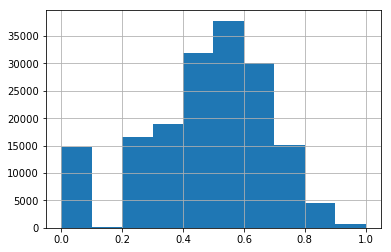

In [24]:
song_hotness_lyrics.hotness.hist()

Seems to look like a gaussian, except for these 0 values:

In [27]:
print("There are {} songs with hotness 0".format(song_hotness_lyrics[song_hotness_lyrics["hotness"] == 0].shape[0]))

There are 14756 songs with hotness 0


That makes almost 15000 songs for which we are somehow "unsure" about. Are those really songs with 0 popularity ?! Maybe they really didn't touch anyone or very few people. But let's look at the bright side: even if we cut them out in our analysis, we are still left with approximately 155000 songs for which we know the popularity value and the lyrics. But we still have to decide what we will do with these 15000 songs, will we keep them or exclude them ? Maybe we will keep them and treat them separately also. 

Anyway, Million Song and Echo Nest have our back covered: we can use another popularity measure which is the play count ! But this value is present in [another dataset](https://labrosa.ee.columbia.edu/millionsong/tasteprofile). If this doesn't work work we might also use the [Yahoo ratings dataset](https://labrosa.ee.columbia.edu/millionsong/pages/tasks-demos#yahoodata) but this one is for artist rating more than song rating so we should be careful if we decide to include it too. So let's proceed with Taste Profile !

# Popularity of a song: the play counts
In this section we look at the number of times a song has been played (the play count) using [this](https://labrosa.ee.columbia.edu/millionsong/tasteprofile)

In [45]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt

%matplotlib inline

In [39]:
PLAY_COUNTS_FILE = "train_triplets.txt"
SONGS_COUNTS_FILE = "songs-counts.csv"

The *train_triplets.txt* file contains triplets of (User, Song, Play count) and it's almost 3GB large. It contains no header and is *Tab* separated.

In [40]:
play_counts = pd.read_table(PLAY_COUNTS_FILE, header=None, names=["users","songs","counts"])
play_counts.head(10)

,users,songs,counts
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBNZDC12A6D4FC103,1
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBVFZR12A6D4F8AE3,1
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXALG12A8C13C108,1
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1


In [41]:
play_counts.describe()

,counts
count,4.837359e+07
mean,2.866859e+00
std,6.437725e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,3.000000e+00
max,9.667000e+03


What we need is the mapping song -> play count. We'll produce a new file containing only this information

In [42]:
songs_counts = play_counts.groupby(by="songs").sum()
songs_counts.head()

,counts
songs,
SOAAADD12AB018A9DD,24
SOAAADE12A6D4F80CC,12
SOAAADF12A8C13DF62,9
SOAAADZ12A8C1334FB,12
SOAAAFI12A6D4F9C66,188


In [44]:
songs_counts.describe()

,counts
count,384546.000000
mean,360.633690
std,3256.809395
min,1.000000
25%,8.000000
50%,32.000000
75%,133.000000
max,726885.000000


We see that we have 384546 songs at disposal here. We also see that there is a huge gap between the minimal number of play counts (1) and the maximal (726885). This indicates simply that songs which are popular are really popular !

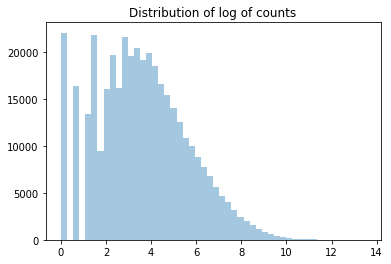

In [57]:
plt.title("Distribution of log of counts")
sns.distplot(songs_counts.apply(np.log), kde=False)

Now we just want to save everything so we don't lose it:

In [43]:
songs_counts.to_csv(SONGS_COUNTS_FILE)